In [1]:
import simtk.unit as unit
import numpy as np

In [2]:
def findline(text, parser):
    index = []
    for n, l in enumerate(text):
        if parser in l:
            index.append(n)
    return index

In [3]:
with open("freq.fchk", "r") as f:
    text = f.readlines()

In [5]:
energy = float(text[findline(text, "Total Energy")[-1]].strip().split()[-1])

In [83]:
def readArray(parser, text):
    start = findline(text, parser)[0]
    num = int(text[start].strip().split()[-1])
    array = np.zeros(num)
    p = 0
    for line in text[start+1:]:
        if line.strip()[0].isalpha():
            break
        for i in line.strip().split():
            array[p] = np.float64(i)
            p += 1
    return array

def readHess(text):
    natom = text[findline(text, "Number of atoms")[0]].strip().split()[-1]
    natom = int(natom)
    hess = readArray("Cartesian Force Constants", text)
    hess_mat = np.zeros((natom*3, natom*3))
    pn = 0
    for pi in range(natom*3):
        for pj in range(pi+1):
            hess_mat[pi,pj] = hess[pn]
            hess_mat[pj,pi] = hess[pn]
            pn += 1
    return unit.Quantity(hess_mat * 627.5, unit.kilocalorie_per_mole / unit.bohr / unit.bohr)

def readMass(text):
    return readArray("Real atomic weights", text)

def readMmat(text):
    mass = readMass(text)
    M = np.zeros((3 * mass.shape[0],))
    for i in range(mass.shape[0]):
        M[3*i:3*(i+1)] = mass[i]
    return unit.Quantity(M, unit.amu)

def readXYZ(text):
    return unit.Quantity(readArray("Current cartesian coordinates", text).reshape((-1,3)), unit.bohr)

In [56]:
hess = readHess(text).value_in_unit(unit.kilocalorie_per_mole / unit.bohr / unit.bohr)
M = readMmat(text).value_in_unit(unit.amu)

In [78]:
V = np.dot(np.dot(np.diag(1. / np.sqrt(M)), hess),np.diag(1. / np.sqrt(M)))

In [81]:
e,v = np.linalg.eig(V)
e = unit.Quantity(e, unit.kilocalorie_per_mole / unit.bohr ** 2 / unit.amu)
e = e.value_in_unit(unit.joule / unit.meter ** 2 / unit.kilogram)
np.sqrt(np.abs(e)) / 2. / np.pi / 2.99792458e10 * np.sign(e)

3718.1569429463525

In [84]:
readXYZ(text)

Quantity(value=array([[ -9.14954938,   0.94030883,  -0.98341726],
       [ -9.45665633,  -1.4578897 ,  -2.57395628],
       [ -6.91369723,  -2.28652327,  -3.68952398],
       [ -5.04835234,  -2.74985199,  -1.54116993],
       [ -4.68265632,  -0.32349277,   0.05213565],
       [ -7.21712866,   0.56263005,   1.13660224],
       [ -7.11425008,  -3.99419318,  -4.84162575],
       [-10.2173486 ,  -2.98471282,  -1.3928869 ],
       [-10.8128202 ,  -1.14403642,  -4.10365368],
       [ -8.50987897,   2.48992394,  -2.20822435],
       [-10.9731937 ,   1.50652558,  -0.18757233],
       [ -5.77936644,  -4.24381278,  -0.31089207],
       [ -4.01776752,   1.14567292,  -1.25342889],
       [ -7.90918228,  -0.8311488 ,   2.50244149],
       [ -6.89007754,   2.34298828,   2.14396611],
       [ -6.22442151,  -0.76419202,  -4.92049158],
       [ -2.52639376,  -3.61724573,  -2.37856049],
       [ -1.24235131,  -2.34038424,  -4.19836487],
       [ -1.20595141,  -5.15622736,  -0.80386871],
       [  1.3116

In [86]:
"123".encode("utf-8").decode("utf-8")

'123'

In [105]:
np.random.choice([999, 1000,1500])

999

In [1]:
json.dumps([0,1,{1:2}])

NameError: name 'json' is not defined

In [1]:
import multifit
import json
import numpy as np

In [2]:
TEMPFILE = "conf.temp"
VAR = np.array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  0.00000000e+00,
                 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                 0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [3]:
from fit import *
HESSFILE = "freq.fchk"
xyz, hess = getCHKHess(HESSFILE)
mass = getCHKMass(HESSFILE)

In [4]:
with open(TEMPFILE, "r") as f:
    template = Template("".join(f))

In [5]:
conf = json.loads(template.render(var=VAR))

In [6]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090, 9091, 9092, 9093, 9094])

In [ ]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090, 9091, 9092, 9093, 9094])
%timeit -n3 score(VAR)

9.08 s ± 217 ms per loop (mean ± std. dev. of 7 runs, 3 loops each)


In [ ]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090, 9091, 9092, 9093])
%timeit -n3 score(VAR)

In [ ]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090, 9091, 9092])
%timeit -n3 score(VAR)

In [ ]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090, 9091])
%timeit -n3 score(VAR)

In [ ]:
score = multifit.multigenHessScore(xyz, hess, mass, template, [9090])
%timeit -n3 score(VAR)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

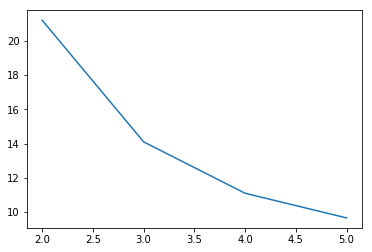

In [16]:
plt.plot([5,4,3,2], [9.66,11.1,14.1,21.2])